# Captsone Project 
## Identifying potential locations for new Steakhouse restaurant in Birmingham

### Business problem
A steakhouse chain would like to identify locations with the most affluent and captive customers (as in resident customers). They would be looking at areas where there is already competition as it would equate to an already established location where customers go. How to identify places with the same type of business together with high catchment area? 

### Methodology
We will be using census data from the UK Office of National Statistique (ONS) together with venues from Foursquare to try finding suitable locations for this business. The ONS data will enable to assess the locations with high restaurants spending residents and high volume of workers. Restaurants hotspots will be located using Foursquare venues and a k-means clustering will be run to group restaurant locations with similar characteristics. Based on the results, a few recommendations will be made.

##### Please note that I had to remove some maps because they were taking too much space and the notebook couldn't be saved in Github.

<a id='0'></a>

## Table of Contents

1. [Import Packages](#1)
2. [Import Data](#2)
3. [ONS Data Exploration](#3)
4. [Get Venues from Foursquare API](#4)
5. [Foursquare Venues Data Exploration](#5)
6. [K-Means Clustering](#6)
7. [Results/Recommendations](#7)


<a name="1"></a>

## 1) Import Packages

[Back to Table of Contents](#0)

In [63]:
# If DLL issue run this in conda prompt
# set CONDA_DLL_SEARCH_MODIFICATION_ENABLE=1 
import numpy as np 
import pandas as pd 

# Import geo libraries
import geopandas as gpd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json # library to handle JSON files
import geojson
import pygeoj
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import geog

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

# map rendering library
import folium 
from folium import plugins


# import k-means from clustering stage
from sklearn.cluster import KMeans

from ipywidgets import interact, fixed
import pysal as ps
from ipywidgets import interact, fixed


# Other packages (not all will be used) 
import lxml.html as lh
import bs4 as bs
import urllib.request as urlreq

import requests # library to handle requests
import scipy

<a id='2'></a>

## 2) Import data

[Back to Table of Contents](#0)

### 2.1) Import ONS Data

This data contains a list of locations by code (form MSOA to OA), the location group, the location latitude and longitude, the total population and the population by age group.

In [3]:
oac_file = "C:/Users/manu_/Documents/Git_Projects/Captsone/Coursera_Capstone/OAC11_All.csv"
oac = pd.read_csv(oac_file)
print(oac.shape)
oac.head()


(5895, 22)


,oa11,lsoa11,msoa11,oac11,msoa11nm,lsoa11nm,Supergroup,Group,Subgroup,OAC,...,longitude,Pop_all,Pop_over_15,0-15,16-21,21-29,30-39,40-49,50-59,60+
0,E00175658,E01033625,E02006899,2B2,Birmingham 138,Birmingham 138D,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,-1.903609,656,640,16,213,290,76,17,29,15
1,E00175626,E01033616,E02006896,3B3,Birmingham 135,Birmingham 135D,Ethnicity central,Endeavouring ethnic mix,Multi-ethnic professional service workers,3B,...,-1.902641,273,211,62,23,93,47,14,11,23
2,E00175622,E01033615,E02006896,2B2,Birmingham 135,Birmingham 135C,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,-1.900211,288,272,16,22,156,54,15,15,10
3,E00175652,E01033620,E02006899,2B2,Birmingham 138,Birmingham 138A,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,-1.901396,251,248,3,43,118,51,21,6,9
4,E00175670,E01033625,E02006899,2B2,Birmingham 138,Birmingham 138D,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,-1.904288,230,215,15,4,96,53,29,15,18


The company is mainly interested in areas a young population between 21 and 39 which would match the profile of their customers.

In [4]:
# First let's add the 21-29 and 30-39 buckets together
oac['Target_Age'] = oac['21-29'] + oac['30-39']
# Calculate the % of the population for the oac
oac['Target_Age_%'] = oac['Target_Age']/oac['Pop_over_15']
oac.sort_values(by='Target_Age_%',ascending=False)

,oa11,lsoa11,msoa11,oac11,msoa11nm,lsoa11nm,Supergroup,Group,Subgroup,OAC,...,Pop_over_15,0-15,16-21,21-29,30-39,40-49,50-59,60+,Target_Age,Target_Age_%
1758,E00175778,E01033623,E02006899,2B2,Birmingham 138,Birmingham 138C,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,210,6,0,122,67,6,13,2,189,0.900000
239,E00175736,E01009378,E02006896,2B2,Birmingham 135,Birmingham 135A,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,114,7,1,76,24,6,4,3,100,0.877193
237,E00175636,E01009378,E02006896,2B2,Birmingham 135,Birmingham 135A,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,309,24,7,174,96,13,10,9,270,0.873786
656,E00175616,E01033564,E02006897,2B2,Birmingham 136,Birmingham 136C,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,243,22,4,128,81,19,8,3,209,0.860082
41,E00175780,E01033623,E02006899,2B2,Birmingham 138,Birmingham 138C,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,213,4,5,129,53,13,7,6,182,0.854460
812,E00175722,E01033559,E02001875,2B2,Birmingham 049,Birmingham 049E,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,415,12,26,219,133,23,9,5,352,0.848193
5,E00175659,E01033625,E02006899,2B2,Birmingham 138,Birmingham 138D,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,656,34,29,361,195,47,15,9,556,0.847561
647,E00175619,E01033564,E02006897,2B2,Birmingham 136,Birmingham 136C,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,292,10,11,145,101,25,3,7,246,0.842466
1756,E00175771,E01033622,E02006899,2B2,Birmingham 138,Birmingham 138B,Cosmopolitans,Inner city students,Multicultural student neighbourhood,2B,...,216,14,16,94,87,12,6,1,181,0.837963
567,E00175667,E01033626,E02006895,3D1,Birmingham 134,Birmingham 134D,Ethnicity central,Aspirational techies,New EU tech workers,3D,...,148,31,5,72,52,11,8,0,124,0.837838


<a id='2.2'></a>

### 2.2) Import Restaurant & Hotel Weekly spending per person

[Back to Table of Contents](#0)

The ONS publishes the average spending by household and group them together with the average occupancy per household. From this data the weekly average spending per person and group.

In [5]:
spending_file = "C:/Users/manu_/Documents/Git_Projects/Captsone/Coursera_Capstone/RestaurantWeeklySpending.csv"
group_spending = pd.read_csv(spending_file)
group_spending = group_spending.drop('Group', axis=1)
group_spending = group_spending.set_index('OAC')
group_spending.head()

,Restaurants and Hotel
OAC,
2D,48.0
2B,36.6
3D,31.2
2A,31.2
5B,28.0


Now let's bring the average weekly spending per person into the main dataset

In [6]:
oac = oac.set_index('OAC').join(group_spending)

In [7]:
oac.reset_index()

,OAC,oa11,lsoa11,msoa11,oac11,msoa11nm,lsoa11nm,Supergroup,Group,Subgroup,...,0-15,16-21,21-29,30-39,40-49,50-59,60+,Target_Age,Target_Age_%,Restaurants and Hotel
0,1A,E00164122,E01032178,E02006700,1A4,Bromsgrove 005,Bromsgrove 005D,Rural residents,Farming communities,Older farming communities,...,5,1,5,5,2,18,158,10,0.052910,21.5
1,1A,E00052313,E01010356,E02002148,1A2,Walsall 039,Walsall 039C,Rural residents,Farming communities,Established farming communities,...,41,6,5,22,30,27,141,27,0.116883,21.5
2,1A,E00158176,E01031028,E02006474,1A3,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Agricultural communities,...,39,10,26,13,47,37,78,39,0.184834,21.5
3,1A,E00158172,E01031028,E02006474,1A2,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Established farming communities,...,82,19,30,31,65,87,164,61,0.154040,21.5
4,1A,E00158153,E01031024,E02006471,1A2,North Warwickshire 004,North Warwickshire 004B,Rural residents,Farming communities,Established farming communities,...,44,21,29,30,49,65,114,59,0.191558,21.5
5,1A,E00158175,E01031028,E02006474,1A3,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Agricultural communities,...,31,11,9,14,32,24,51,23,0.163121,21.5
6,1A,E00159297,E01031243,E02006504,1A4,Stratford-on-Avon 001,Stratford-on-Avon 001B,Rural residents,Farming communities,Older farming communities,...,37,21,20,18,29,66,169,38,0.117647,21.5
7,1A,E00163861,E01032123,E02006704,1A2,Bromsgrove 009,Bromsgrove 009B,Rural residents,Farming communities,Established farming communities,...,32,13,9,21,43,39,100,30,0.133333,21.5
8,1A,E00163858,E01032123,E02006704,1A4,Bromsgrove 009,Bromsgrove 009B,Rural residents,Farming communities,Older farming communities,...,38,20,19,19,37,63,82,38,0.158333,21.5
9,1A,E00158970,E01031183,E02006509,1A2,Stratford-on-Avon 006,Stratford-on-Avon 006A,Rural residents,Farming communities,Established farming communities,...,34,12,11,13,26,42,77,24,0.132597,21.5


Now let's calculate the average Restaurants & Hotel Spending by location (OAC)

In [8]:
oac['Total Spending'] = oac['Pop_over_15']*oac['Restaurants and Hotel']
oac['Total Target Spending'] = oac['Target_Age']*oac['Restaurants and Hotel']
oac.head()

,oa11,lsoa11,msoa11,oac11,msoa11nm,lsoa11nm,Supergroup,Group,Subgroup,City,...,21-29,30-39,40-49,50-59,60+,Target_Age,Target_Age_%,Restaurants and Hotel,Total Spending,Total Target Spending
OAC,,,,,,,,,,,,,,,,,,,,,
1A,E00164122,E01032178,E02006700,1A4,Bromsgrove 005,Bromsgrove 005D,Rural residents,Farming communities,Older farming communities,Bromsgrove,...,5,5,2,18,158,10,0.052910,21.5,4063.5,215.0
1A,E00052313,E01010356,E02002148,1A2,Walsall 039,Walsall 039C,Rural residents,Farming communities,Established farming communities,Walsall,...,5,22,30,27,141,27,0.116883,21.5,4966.5,580.5
1A,E00158176,E01031028,E02006474,1A3,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Agricultural communities,North Warwickshire,...,26,13,47,37,78,39,0.184834,21.5,4536.5,838.5
1A,E00158172,E01031028,E02006474,1A2,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Established farming communities,North Warwickshire,...,30,31,65,87,164,61,0.154040,21.5,8514.0,1311.5
1A,E00158153,E01031024,E02006471,1A2,North Warwickshire 004,North Warwickshire 004B,Rural residents,Farming communities,Established farming communities,North Warwickshire,...,29,30,49,65,114,59,0.191558,21.5,6622.0,1268.5


In [9]:
oac['GroupBy'] = '1'

Finally create summary tables at LSOA and MSOA level with a summary of the weekly spending

In [10]:
oac.rename(columns={'lsoa11':'lsoa11cd','msoa11':'msoa11cd'}, inplace=True)
oac

,oa11,lsoa11cd,msoa11cd,oac11,msoa11nm,lsoa11nm,Supergroup,Group,Subgroup,City,...,30-39,40-49,50-59,60+,Target_Age,Target_Age_%,Restaurants and Hotel,Total Spending,Total Target Spending,GroupBy
OAC,,,,,,,,,,,,,,,,,,,,,
1A,E00164122,E01032178,E02006700,1A4,Bromsgrove 005,Bromsgrove 005D,Rural residents,Farming communities,Older farming communities,Bromsgrove,...,5,2,18,158,10,0.052910,21.5,4063.5,215.0,1
1A,E00052313,E01010356,E02002148,1A2,Walsall 039,Walsall 039C,Rural residents,Farming communities,Established farming communities,Walsall,...,22,30,27,141,27,0.116883,21.5,4966.5,580.5,1
1A,E00158176,E01031028,E02006474,1A3,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Agricultural communities,North Warwickshire,...,13,47,37,78,39,0.184834,21.5,4536.5,838.5,1
1A,E00158172,E01031028,E02006474,1A2,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Established farming communities,North Warwickshire,...,31,65,87,164,61,0.154040,21.5,8514.0,1311.5,1
1A,E00158153,E01031024,E02006471,1A2,North Warwickshire 004,North Warwickshire 004B,Rural residents,Farming communities,Established farming communities,North Warwickshire,...,30,49,65,114,59,0.191558,21.5,6622.0,1268.5,1
1A,E00158175,E01031028,E02006474,1A3,North Warwickshire 007,North Warwickshire 007D,Rural residents,Farming communities,Agricultural communities,North Warwickshire,...,14,32,24,51,23,0.163121,21.5,3031.5,494.5,1
1A,E00159297,E01031243,E02006504,1A4,Stratford-on-Avon 001,Stratford-on-Avon 001B,Rural residents,Farming communities,Older farming communities,Stratford-on-Avon,...,18,29,66,169,38,0.117647,21.5,6944.5,817.0,1
1A,E00163861,E01032123,E02006704,1A2,Bromsgrove 009,Bromsgrove 009B,Rural residents,Farming communities,Established farming communities,Bromsgrove,...,21,43,39,100,30,0.133333,21.5,4837.5,645.0,1
1A,E00163858,E01032123,E02006704,1A4,Bromsgrove 009,Bromsgrove 009B,Rural residents,Farming communities,Older farming communities,Bromsgrove,...,19,37,63,82,38,0.158333,21.5,5160.0,817.0,1


In [11]:
# Let's group the data by lsoa11 and by supergroup and group
df1 = oac.groupby(['lsoa11cd'])['Total Spending','Total Target Spending','Target_Age','Pop_over_15'].agg('sum')
df2 = oac.groupby('GroupBy')['Total Spending','Total Target Spending'].agg('sum')
lsoa11_spending = pd.DataFrame(df1)

lsoa11_spending['Target_Spending_%_in_Area']=round(lsoa11_spending['Total Target Spending']/lsoa11_spending['Total Spending']*100,2)
lsoa11_spending['Target_Spending_%']=round((lsoa11_spending['Total Target Spending']/df2['Total Target Spending'].values)*100,2)
lsoa11_spending['Target_Spending_%_vs_All']=round((lsoa11_spending['Total Target Spending']/df2['Total Spending'].values)*100,2)

#nm_df.sort_values(by='Target_Age_%',ascending=False)
lsoa11_spending.sort_values(by='Target_Spending_%',ascending=False)

,Total Spending,Total Target Spending,Target_Age,Pop_over_15,Target_Spending_%_in_Area,Target_Spending_%,Target_Spending_%_vs_All
lsoa11cd,,,,,,,
E01033634,139758.4,69263.4,2262,4572,49.56,0.76,0.24
E01033617,131277.6,65851.2,1932,3849,50.16,0.72,0.23
E01033622,89962.8,64342.8,1758,2458,71.52,0.71,0.22
E01033557,90548.4,64269.6,1756,2474,70.98,0.71,0.22
E01033625,75871.8,54387.6,1486,2073,71.68,0.60,0.19
E01033561,120503.0,47219.6,1617,4167,39.19,0.52,0.16
E01033567,61158.6,45347.4,1239,1671,74.15,0.50,0.16
E01033559,59975.4,44494.0,1327,1812,74.19,0.49,0.15
E01009284,76135.8,41470.1,1704,3304,54.47,0.46,0.14


<a id='2.3'></a>

### 2.3) Import Working Population (LSOA level)

This dataset contains the working population based on the ONS 2011 census. It is at lsao11cd level.

[Back to Table of Contents](#0)

In [12]:
file = "C:/Users/manu_/Documents/Git_Projects/Captsone/Coursera_Capstone/Working_Population.csv"
work_pop = pd.read_csv(file)
work_pop = work_pop.set_index('lsoa11cd')
work_pop.head()

,lsoa11nm,Pop
lsoa11cd,,
E01009417,Birmingham 001A,187
E01009418,Birmingham 001B,258
E01009419,Birmingham 001C,251
E01009433,Birmingham 001D,223
E01009415,Birmingham 002A,235


<a id='2.4'></a>

### 2.4) Import LSOA shape files

The LSOA shape files are avaible on the UK ONS geoportal.

[Back to Table of Contents](#0)

A first step is to change the projection (crs) from Ordenance Survey grid coordinates to latitude/longitude coordinates for each geometry.

In [84]:
tmp = gpd.GeoDataFrame.from_file("C:/Users/manu_/Documents/Git_Projects/Captsone/Coursera_Capstone/Shapes/LSOA.shp")
tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
tmpWGS84.to_file('wardWGS84.shp')

Let's display the shapes. Some shapes are quite small so it will look like there are missing geometries but they are all there.

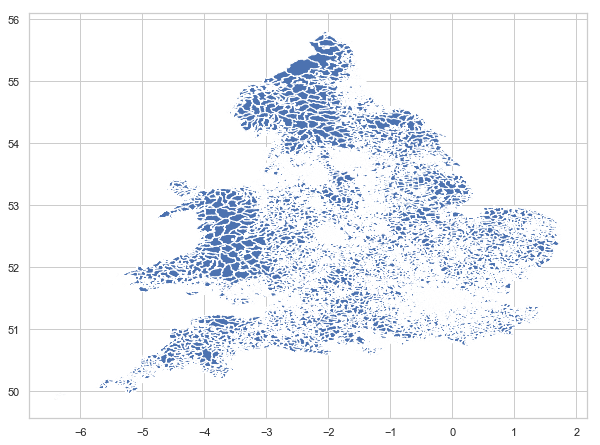

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tmpWGS84.plot(ax=ax)

We do not need the whole of England shapes. Create a filter only for the lsoa which are in Birmingham.

In [86]:
lsoa11_spending = lsoa11_spending.reset_index()
shapefile_filter = lsoa11_spending['lsoa11cd']
shapefile_filter

0       E01008881
1       E01008882
2       E01008883
3       E01008884
4       E01008885
5       E01008886
6       E01008887
7       E01008888
8       E01008889
9       E01008890
10      E01008891
11      E01008892
12      E01008893
13      E01008894
14      E01008895
15      E01008896
16      E01008897
17      E01008898
18      E01008899
19      E01008901
20      E01008905
21      E01008906
22      E01008907
23      E01008909
24      E01008910
25      E01008911
26      E01008913
27      E01008914
28      E01008915
29      E01008916
          ...    
1152    E01033621
1153    E01033622
1154    E01033623
1155    E01033624
1156    E01033625
1157    E01033626
1158    E01033627
1159    E01033628
1160    E01033629
1161    E01033630
1162    E01033631
1163    E01033632
1164    E01033633
1165    E01033634
1166    E01033635
1167    E01033636
1168    E01033637
1169    E01033638
1170    E01033639
1171    E01033640
1172    E01033641
1173    E01033642
1174    E01033643
1175    E01033644
1176    E0

Now filter the geopanda dataframe using this filter

In [87]:
shapefile_filtered = tmpWGS84.lsoa11cd.isin(shapefile_filter)
shapefile2_final = tmpWGS84[shapefile_filtered]

In [89]:
shapefile2_final.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry
8648,8649,E01008881,Birmingham 067A,Birmingham 067A,396866.952164,3912.346530,POLYGON ((-1.816864229666967 52.46865419023455...
8649,8650,E01008882,Birmingham 066A,Birmingham 066A,245892.168075,2891.905920,POLYGON ((-1.822765275835135 52.46637757723988...
8650,8651,E01008883,Birmingham 078A,Birmingham 078A,393912.155437,3750.802882,POLYGON ((-1.827001979533841 52.46244054097156...
8651,8652,E01008884,Birmingham 078B,Birmingham 078B,698426.085822,5451.077346,POLYGON ((-1.834751339305804 52.46373806161364...
8652,8653,E01008885,Birmingham 076A,Birmingham 076A,192835.085362,2807.790990,"POLYGON ((-1.809149820821694 52.459192315326, ..."


Now the geometries are showing latitude and longitude. Let's plet teh shape to check it worked.

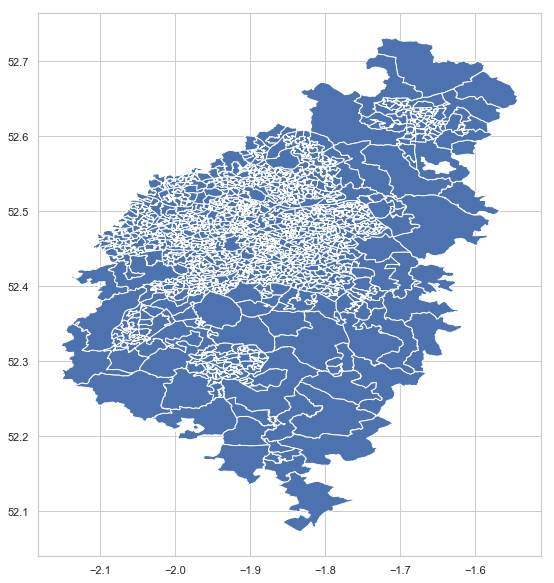

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
shapefile2_final.plot(ax=ax)

The last step is to create a GeoJSON file that will be used by Folium

In [ ]:
shapefile2_final.to_file("LSOA_Birmingham.json", driver="GeoJSON")

Set the lat/long of Birmingham city centre, create a map object + the link to the JSON file

In [13]:
latitude  = 52.480141 
longitude = -1.896341
m = folium.Map(location=[latitude, longitude], zoom_start=13)
lsoa= r"LSOA_Birmingham.json"

In [15]:
lsoa11_spending = lsoa11_spending.reset_index()
#msoa11_spending.rename(columns={'lsoa11':'lsoa11cd'}, inplace=True)
lsoa11_spending

,lsoa11cd,Total Spending,Total Target Spending,Target_Age,Pop_over_15,Target_Spending_%_in_Area,Target_Spending_%,Target_Spending_%_vs_All
0,E01008881,18722.9,5739.0,396,1276,30.65,0.06,0.02
1,E01008882,15128.0,5697.4,467,1240,37.66,0.06,0.02
2,E01008883,21181.6,8332.0,599,1520,39.34,0.09,0.03
3,E01008884,18092.6,7844.6,643,1483,43.36,0.09,0.03
4,E01008885,20995.2,6370.8,317,1049,30.34,0.07,0.02
5,E01008886,18051.6,5964.9,435,1254,33.04,0.07,0.02
6,E01008887,15478.7,5914.2,441,1156,38.21,0.07,0.02
7,E01008888,27060.0,8646.4,415,1291,31.95,0.10,0.03
8,E01008889,20142.5,7771.1,571,1444,38.58,0.09,0.03
9,E01008890,22447.0,8779.6,578,1469,39.11,0.10,0.03


<a id='2.5'></a>

### 2.5) Select LSOA within a 3km radius from the city centre
This is this to narrow the location in order to limit the volume of call that will be made to the Foursquare API
Get the LSOA within a 3 km radius from the city centre. We will use E01033625 as the LSOA the closest to the centre of Birmingham

[Back to Table of Contents](#0)

In [103]:
lsoa = "C:/Users/manu_/Documents/Git_Projects/Captsone/Coursera_Capstone/Shapes/LSOA.shp"
w_dist1kmB = ps.lib.weights.DistanceBand.from_shapefile(lsoa, threshold=3000, idVariable='lsoa11cd')

C:\Users\manu_\Anaconda3\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 1857 disconnected observations 
  Island ids: E01005409, E01007426, E01007559, E01007625, E01007956, E01008128, E01010855, E01010887, E01010918, E01010955, E01011182, E01011309, E01011959, E01012132, E01012137, E01012198, E01012334, E01012920, E01012922, E01012925, E01012926, E01012934, E01012937, E01012981, E01012984, E01012986, E01012987, E01012988, E01012989, E01012990, E01012991, E01012992, E01013016, E01013020, E01013021, E01013022, E01013028, E01013029, E01013030, E01013034, E01013035, E01013048, E01013050, E01013057, E01013072, E01013076, E01013078, E01013081, E01013087, E01013119, E01013122, E01013125, E01013126, E01013127, E01013242, E01013243, E01013246, E01013267, E01013268, E01013270, E01013274, E01013306, E01013308, E01013309, E01013322, E01013323, E01013329, E01013450, E01013451, E01013452, E01013787, E01013788, E01013789, E01013790, E01013795, E01013796, E01013809, E010139

C:\Users\manu_\Anaconda3\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 1857 disconnected observations 
  Island ids: E01005409, E01007426, E01007559, E01007625, E01007956, E01008128, E01010855, E01010887, E01010918, E01010955, E01011182, E01011309, E01011959, E01012132, E01012137, E01012198, E01012334, E01012920, E01012922, E01012925, E01012926, E01012934, E01012937, E01012981, E01012984, E01012986, E01012987, E01012988, E01012989, E01012990, E01012991, E01012992, E01013016, E01013020, E01013021, E01013022, E01013028, E01013029, E01013030, E01013034, E01013035, E01013048, E01013050, E01013057, E01013072, E01013076, E01013078, E01013081, E01013087, E01013119, E01013122, E01013125, E01013126, E01013127, E01013242, E01013243, E01013246, E01013267, E01013268, E01013270, E01013274, E01013306, E01013308, E01013309, E01013322, E01013323, E01013329, E01013450, E01013451, E01013452, E01013787, E01013788, E01013789, E01013790, E01013795, E01013796, E01013809, E010139

The above has got for each LSOA the neighboring LSOAs within the 3km radius. We only need to filter by using a city centre lsoa to get a list of the LSOA that we will use going forward.

In [104]:
lsoa_citycentre ='E01033625'
selection = pd.DataFrame([w_dist1kmB[lsoa_citycentre]])
selection = selection.transpose()
selection=selection.reset_index()
selection= selection.drop(0, axis=1)
col =['lsoa11cd']
selection.columns = col
selection.iloc[-1] = [lsoa_citycentre]
print(selection.shape)
selection.head()

(75, 1)


,lsoa11cd
0,E01008905
1,E01008906
2,E01008907
3,E01008909
4,E01008910


So there are 75 LSOA in a 3km radius from the centre. Let's plot these on a map using Geopandas

In [105]:
b_filter = selection['lsoa11cd']

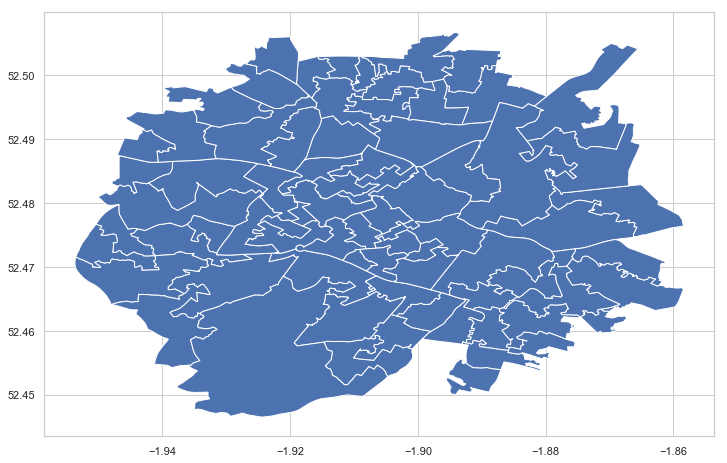

In [111]:
birmingham_filtered = tmpWGS84.lsoa11cd.isin(b_filter)
birmingham_shapes = tmpWGS84[birmingham_filtered]
fig, ax = plt.subplots(1, 1, figsize=(12,8))
birmingham_shapes.plot(ax=ax)

So there are 75 LSOA within 3km of Birmingham city centre

<a id='#3'></a>

## 3) ONS Data exploration

[Back to Table of Contents](#0)

### 3.1) Create new dataframe the for selected locations 

Create a new dataframe for these selected 75 locations

In [21]:
# First let's group the data at lsoa level
lsoa_data = pd.DataFrame(oac.groupby('lsoa11cd')['Target_Age','Total Target Spending','Total Spending','Pop_over_15']
                        .agg('sum'))
# sort the datafrane by total spending value
lsoa_data = lsoa_data.sort_values(by='Total Spending',ascending=False)
# reset the index
lsoa_data = lsoa_data.reset_index()
# add the spending but in £K (1000's)
lsoa_data['Total Target Spending £k'] = round(lsoa_data['Total Target Spending']/1000,1)
lsoa_data['Total Spending £k'] = round(lsoa_data['Total Spending']/1000,1)



In [23]:
print(lsoa_data.shape)
lsoa_data.describe()


(1182, 7)


,Target_Age,Total Target Spending,Total Spending,Pop_over_15,Total Target Spending £k,Total Spending £k
count,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000
mean,430.058376,7692.587394,24651.753553,1334.009306,7.693063,24.652115
std,207.749770,5744.454837,11859.978942,350.442228,5.745002,11.860426
min,20.000000,372.000000,1897.200000,102.000000,0.400000,1.900000
25%,312.000000,5603.075000,17120.125000,1178.250000,5.600000,17.100000
50%,386.500000,6613.300000,22943.900000,1277.000000,6.600000,22.950000
75%,497.500000,7939.825000,29556.500000,1419.750000,7.900000,29.600000
max,2262.000000,69263.400000,194016.800000,6521.000000,69.300000,194.000000


In [24]:
lsoa_data = lsoa_data.merge(selection['lsoa11cd'], on='lsoa11cd')
print(lsoa_data.shape)
lsoa_data.head()

(75, 7)


,lsoa11cd,Target_Age,Total Target Spending,Total Spending,Pop_over_15,Total Target Spending £k,Total Spending £k
0,E01033631,1355,40290.4,194016.8,6521,40.3,194.0
1,E01033617,1932,65851.2,131277.6,3849,65.9,131.3
2,E01033561,1617,47219.6,120503.0,4167,47.2,120.5
3,E01033557,1756,64269.6,90548.4,2474,64.3,90.5
4,E01033622,1758,64342.8,89962.8,2458,64.3,90.0


The below was to describe the dataframe

In [26]:
desc = pd.DataFrame(lsoa_data.describe())
desc['Avg Spend by Person - Target']=desc['Total Target Spending']/desc['Target_Age']
desc['Avg Spend by Person - All']=desc['Total Spending']/desc['Pop_over_15']
desc

,Target_Age,Total Target Spending,Total Spending,Pop_over_15,Total Target Spending £k,Total Spending £k,Avg Spend by Person - Target,Avg Spend by Person - All
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,1.000000,1.000000
mean,768.866667,17326.081333,33999.561333,1634.573333,17.326667,34.006667,22.534572,20.800267
std,382.914264,15995.566048,30262.537397,810.237105,15.995906,30.262707,41.773231,37.350224
min,283.000000,3452.600000,10321.200000,839.000000,3.500000,10.300000,12.200000,12.301788
25%,483.500000,6380.500000,15250.000000,1229.500000,6.400000,15.250000,13.196484,12.403416
50%,639.000000,9568.400000,24946.100000,1365.000000,9.600000,24.900000,14.974022,18.275531
75%,971.000000,22845.600000,45236.500000,1774.000000,22.850000,45.250000,23.527909,25.499718
max,1932.000000,65851.200000,194016.800000,6521.000000,65.900000,194.000000,34.084472,29.752615


<a id='3.2'></a>

### 3.2) Check the spending in the selected locations

[Back to Table of Contents](#0)

Create a boxplot to understand the distribution of the target population spending.

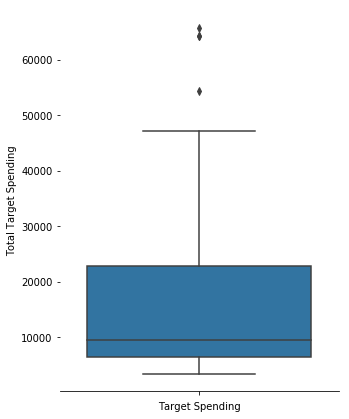

In [44]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(5, 7))

sns.boxplot(ax=ax1, y='Total Target Spending',data=lsoa_data)
#sns.boxplot(ax=ax2, y='Total Spending',data=lsoa_data)

ax1.set(xlabel="Target Spending")
#ax2.set(xlabel="Total Spending")

sns.despine(left=True, bottom=False)

So there are a few outliers (3).

New dataframe for the target group sorted by target spending (not really necessary)

In [47]:
lsoa_data_target = lsoa_data.sort_values(by='Total Target Spending',ascending=False)
lsoa_data_target = lsoa_data_target.reset_index()
lsoa_data_target.head()

,index,lsoa11cd,Target_Age,Total Target Spending,Total Spending,Pop_over_15,Total Target Spending £k,Total Spending £k
0,1,E01033617,1932,65851.2,131277.6,3849,65.9,131.3
1,4,E01033622,1758,64342.8,89962.8,2458,64.3,90.0
2,3,E01033557,1756,64269.6,90548.4,2474,64.3,90.5
3,5,E01033625,1486,54387.6,75871.8,2073,54.4,75.9
4,2,E01033561,1617,47219.6,120503.0,4167,47.2,120.5


Let's add a few more variables to the selected lsoa dataframe: avg latitude and longitude (centroids) + the working population in these areas.

In [48]:
lsoa_centroids = pd.DataFrame(oac.groupby('lsoa11cd')['latitude','longitude'].mean())
lsoa_centroids.reset_index()
lsoa_data_target = lsoa_data_target.merge(lsoa_centroids, on='lsoa11cd')
lsoa_data_target = lsoa_data_target.set_index('lsoa11cd', drop=False)
lsoa_data_target['Work Pop']=work_pop['Pop']
print(lsoa_data_target.shape)
lsoa_data_target.head()

(75, 11)


,index,lsoa11cd,Target_Age,Total Target Spending,Total Spending,Pop_over_15,Total Target Spending £k,Total Spending £k,latitude,longitude,Work Pop
lsoa11cd,,,,,,,,,,,
E01033617,1,E01033617,1932,65851.2,131277.6,3849,65.9,131.3,52.484849,-1.891885,14271
E01033622,4,E01033622,1758,64342.8,89962.8,2458,64.3,90.0,52.483494,-1.906255,3652
E01033557,3,E01033557,1756,64269.6,90548.4,2474,64.3,90.5,52.474878,-1.908052,2816
E01033625,5,E01033625,1486,54387.6,75871.8,2073,54.4,75.9,52.477839,-1.904216,6381
E01033561,2,E01033561,1617,47219.6,120503.0,4167,47.2,120.5,52.485021,-1.883208,10735


Let's plot these locations on a map with a focus on the weekly spending by the target population

In [ ]:
latitude  = 52.480141 
longitude = -1.896341
m = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale = True)
lsoa= r"LSOA_Birmingham.json"
folium.Choropleth(
            geo_data=lsoa, 
             data=lsoa_data_target, 
             key_on='feature.properties.lsoa11cd',
             columns=['lsoa11cd', 'Total Target Spending £k'], 
            nan_fill_color='white',
            nan_fill_opacity=0,
             fill_color='RdBu',
                fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='LSOA by Target Spending (£k)',
            highlight=True
).add_to(m)

for idx, row in lsoa_data_target.iterrows():
    popup = idx
    folium.CircleMarker([row['latitude'], row['longitude']],radius=0.5, tooltip=popup).add_to(m)

# display map
m

The highest spending from the target population is done in areas close to the city center (6 lsoa in the darker shade of blue).

Now we are displaying the top 20 locations in an horizontal stacked bar chart side by side

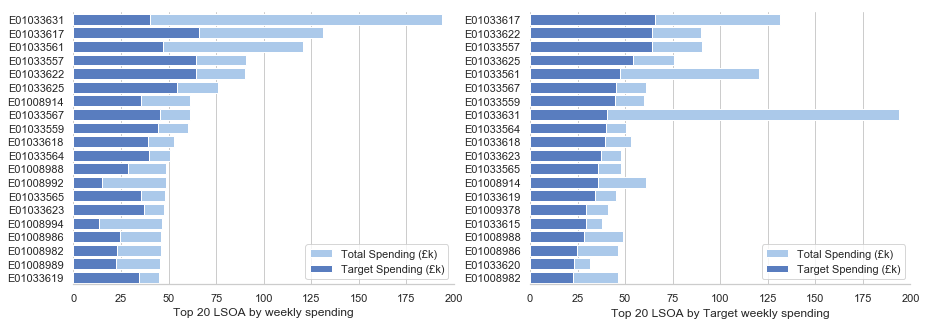

In [547]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))

# Load the example car crash dataset
#top_lsoa_sns = sns.load_dataset(top_lsoa) #.sort_values("total", ascending=False)

# Plot the total spending
sns.set_color_codes("pastel")
sns.barplot(ax=ax1, x="Total Spending £k", y="lsoa11cd", data=lsoa_data.head(20),
            label="Total Spending (£k)", color="b")

# Plot the target spending
sns.set_color_codes("muted")
sns.barplot(ax=ax1, x="Total Target Spending £k", y="lsoa11cd", data=lsoa_data.head(20),
            label="Target Spending (£k)", color="b")

# Add a legend and informative axis label
ax1.legend(ncol=1, loc="lower right", frameon=True)
ax1.set(xlim=(0, 200), ylabel="",
       xlabel="Top 20 LSOA by weekly spending")


sns.set_color_codes("pastel")
sns.barplot(ax=ax2, x="Total Spending £k", y="lsoa11cd", data=lsoa_data_target.head(20),
            label="Total Spending (£k)", color="b")

# Plot the total spending
sns.set_color_codes("muted")
sns.barplot(ax=ax2, x="Total Target Spending £k", y="lsoa11cd", data=lsoa_data_target.head(20),
            label="Target Spending (£k)", color="b")

# Add a legend and informative axis label
ax2.legend(ncol=1, loc="lower right", frameon=True)
ax2.set(xlim=(0, 200), ylabel="",
       xlabel="Top 20 LSOA by Target weekly spending")

sns.despine(left=True, bottom=False)

Interestingly the location with the most spending in restaurants & hotels (E01033631) is not the top area for residents in the target age group (8th position). This indicates an older population living in E01033631 (the top location). If opening a restaurant with a wider target age this location would need investigated (what is the offer in the area).

Check the working population distribution using a boxplot

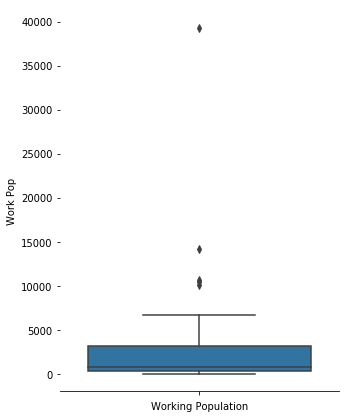

In [49]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(5, 7))

sns.boxplot(ax=ax1, y='Work Pop',data=lsoa_data_target)
#sns.boxplot(ax=ax2, y='Total Spending',data=lsoa_data)

ax1.set(xlabel="Working Population")
#ax2.set(xlabel="Total Spending")

sns.despine(left=True, bottom=False)

Let's now create another map but with the working population

In [ ]:
latitude  = 52.480141 
longitude = -1.896341
m2 = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale = True)
lsoa= r"LSOA_Birmingham.json"
folium.Choropleth(
            geo_data=lsoa, 
             data=lsoa_data_target, 
             key_on='feature.properties.lsoa11cd',
             columns=['lsoa11cd', 'Work Pop'], 
            nan_fill_color='white',
            nan_fill_opacity=0,
             fill_color='RdBu',
                fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Working Population Density by LSOA',
            highlight=True
).add_to(m2)

for idx, row in lsoa_data_target.iterrows():
    popup = idx
    folium.CircleMarker([row['latitude'], row['longitude']],radius=0.5, tooltip=popup).add_to(m2)

# display map
m2

Create a horizontal bar graph of the working population

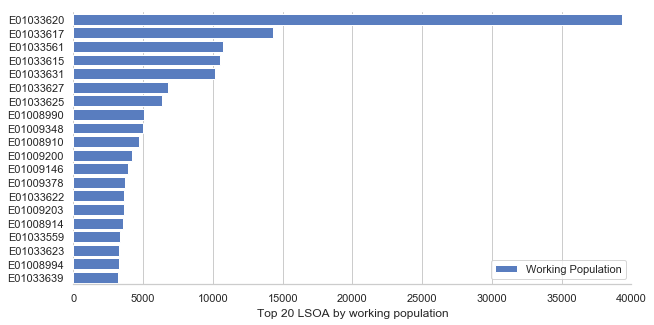

In [51]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))

# Load the example car crash dataset
#top_lsoa_sns = sns.load_dataset(top_lsoa) #.sort_values("total", ascending=False)

sns.set_color_codes("muted")
sns.barplot(ax=ax1, x="Work Pop", y="lsoa11cd", data=lsoa_data_target.sort_values("Work Pop", ascending=False).head(20),
            label="Working Population", color="b")

# Add a legend and informative axis label
ax1.legend(ncol=1, loc="lower right", frameon=True)
ax1.set(xlim=(0, 40000), ylabel="",
       xlabel="Top 20 LSOA by working population")

sns.despine(left=True, bottom=False)

As expected the working population is concentrated in the city center. It may seem obvious but the likely place for a new restaurants is going to be somewhere in between the city centre and the areas where the spending is high in the target population.

Let's see the areas with the highest spending but also the highest volume of workers.

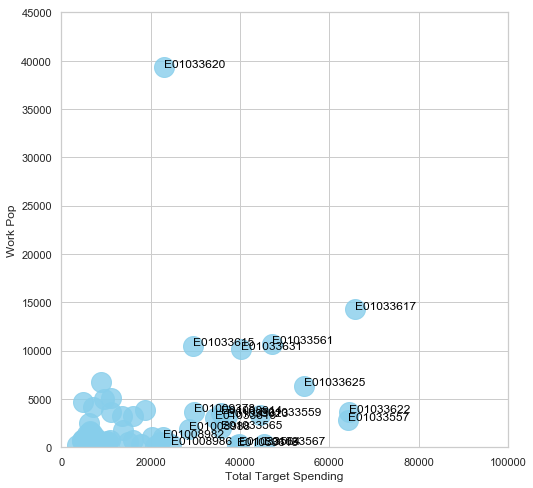

In [574]:
f, ax = plt.subplots(figsize=(8, 8))

# basic plot
p1=sns.regplot(data=lsoa_data_target, x="Total Target Spending", y="Work Pop", 
               fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,lsoa_data_target.head(20).shape[0]):
     p1.text(lsoa_data_target["Total Target Spending"][line]+0.2, lsoa_data_target["Work Pop"][line], lsoa_data_target['lsoa11cd'][line], 
             horizontalalignment='left', size='medium', color='black') #, weight='semibold')
ax.set_ylim(0, 45000)
ax.set_xlim(0, 100000)
plt.show()

The scatter plot help identify locations with high spending and high workers. Location of interest can be narrowed down to 8 locations: ['E01033620','E01033617','E01033561','E01033625','E01033622','E01033557','E01033631','E01033615']. 

E01033620 is an outlier. Let's remove it temporarily only to see the data a bit better.

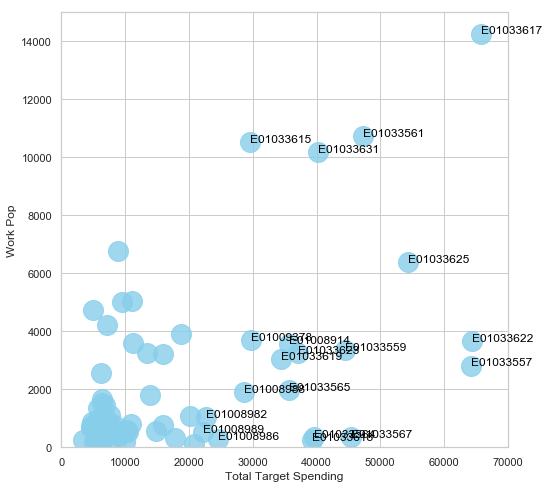

In [584]:
include = lsoa_data_target['lsoa11cd'] != 'E01033620'
lsoa_data_tmp = lsoa_data_target[include]

f, ax = plt.subplots(figsize=(8, 8))

# basic plot
p1=sns.regplot(data=lsoa_data_tmp, x="Total Target Spending", y="Work Pop", 
               fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,lsoa_data_tmp.head(20).shape[0]):
     p1.text(lsoa_data_tmp["Total Target Spending"][line]+0.2, lsoa_data_tmp["Work Pop"][line], lsoa_data_tmp['lsoa11cd'][line], 
             horizontalalignment='left', size='medium', color='black') #, weight='semibold')
ax.set_ylim(0, 15000)
ax.set_xlim(0, 70000)
plt.show()

In [ ]:
latitude  = 52.480141 
longitude = -1.896341
m2 = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale = True)
lsoa= r"LSOA_Birmingham.json"
folium.Choropleth(
            geo_data=lsoa, 
             data=lsoa_data_tmp, 
             key_on='feature.properties.lsoa11cd',
             columns=['lsoa11cd', 'Work Pop'], 
            nan_fill_color='white',
            nan_fill_opacity=0,
             fill_color='RdBu',
                fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Working Population Density by LSOA (excluding the City Centre)',
            highlight=True
).add_to(m2)

for idx, row in lsoa_data_tmp.iterrows():
    popup = idx
    folium.CircleMarker([row['latitude'], row['longitude']],radius=0.5, tooltip=popup).add_to(m2)

# display map
m2

Ok this is a bit easier to read. We can already see that E01033617 appear to have a high volume of workers together with the highest spending. But before jumping to any conclusions, we now need to understand what is the offer around these locations. No restaurants in this particular location is not necessarily an opportunity.

<a id='4'></a>

## 4) Get the Foursquare data at Outpout Area level (LSOA11)

[Back to Table of Contents](#0)

### 4.1) Get the top 200 venues within 500m  using Foursquare API


#### Get the centroids for each lsoa
The dataset is at OAC level which is a child of LSOA. We need to calculate the centroids

In [601]:
s2 = oac.merge(s2['lsoa11cd'],on='lsoa11cd')
lsoa_centroids = pd.DataFrame(oac.groupby('lsoa11cd')['latitude','longitude'].mean())
lsoa_centroids=lsoa_centroids.reset_index()
lsoa_centroids.head()

,lsoa11cd,latitude,longitude
0,E01033557,52.474878,-1.908052
1,E01033561,52.485021,-1.883208
2,E01033615,52.475000,-1.898934
3,E01033617,52.484849,-1.891885
4,E01033620,52.479151,-1.899140


#### Define Foursquare Credentials and Version:

In [602]:
CLIENT_ID = 'TGNOTR10ULUNC13TPQRCE2CVK0ZUZKYDAZNRVMSIIKXVVTMB' # your Foursquare ID
CLIENT_SECRET = 'NMB4GT2GZMKJBSXCUGTSUWXQ02TFVIMBKHJGKYHEDJCRHS45' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TGNOTR10ULUNC13TPQRCE2CVK0ZUZKYDAZNRVMSIIKXVVTMB
CLIENT_SECRET:NMB4GT2GZMKJBSXCUGTSUWXQ02TFVIMBKHJGKYHEDJCRHS45


#### Define limit or venues and the radius to use:

In [603]:
LIMIT = 200
radius = 500
latitude  = 52.480141 
longitude = -1.896341

#### Use the fonction from the lab to get the venues:

In [604]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['lsoa11cd', 
                  'LSOA Latitude', 
                  'LSOA Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get all the venues in Birmingham.

In [766]:
Birmingham_venues = getNearbyVenues(names=lsoa_data_target['lsoa11cd'],
                                   latitudes=lsoa_data_target['latitude'],
                                   longitudes=lsoa_data_target['longitude']
                                  )

E01033617
E01033622
E01033557
E01033625
E01033561
E01033567
E01033559
E01033631
E01033564
E01033618
E01033623
E01033565
E01008914
E01033619
E01009378
E01033615
E01008988
E01008986
E01033620
E01008982
E01008989
E01033626
E01033624
E01009146
E01008987
E01033639
E01033616
E01008992
E01009345
E01008994
E01009203
E01008990
E01009140
E01033628
E01009153
E01009360
E01008984
E01033637
E01009348
E01009152
E01033627
E01008995
E01009358
E01009182
E01009365
E01008991
E01009200
E01033638
E01009375
E01033640
E01009141
E01009376
E01009346
E01008907
E01009355
E01009204
E01009199
E01009367
E01009143
E01008997
E01008906
E01008905
E01008913
E01009363
E01009364
E01008996
E01009368
E01009366
E01009362
E01008911
E01008910
E01009379
E01008909
E01009347
E01009374


#### Size of the resulting dataframe

In [767]:
print(Birmingham_venues.shape)
Birmingham_venues.head()

(1465, 7)


,lsoa11cd,LSOA Latitude,LSOA Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,E01033617,52.484849,-1.891885,Boston Tea Party,52.483028,-1.893479,Café
1,E01033617,52.484849,-1.891885,The Jekyll & Hyde,52.483560,-1.895151,Pub
2,E01033617,52.484849,-1.891885,Scruffy Murphy's,52.482146,-1.892448,Rock Club
3,E01033617,52.484849,-1.891885,The Sir Doug Ellis Woodcock Sports Centre,52.486192,-1.886339,Gym / Fitness Center
4,E01033617,52.484849,-1.891885,Philpotts,52.483104,-1.896114,Sandwich Place


### 4.2) Restaurant Venues


#### Create a new dataframe containing only restaurants from the data
We need to be able to identify restaurants in Birmingham. We will create a higher level category variable 'Restaurant'. For this we will first group all the venues by Venue Category then manually create the Restaurant category. The work has been done in Excel.

In [806]:
Birmingham_categories = Birmingham_venues.groupby('Venue Category').count()

In [808]:
Birmingham_categories.to_csv('Birmingham_categories_v3.csv')

This step required a manual check of the categories in order to identify restaurants only, the results of the manual assignment of Main Category is then loaded:

In [810]:
# All venue category and main category from csv file
cat = pd.read_csv('Birmingham_categories_v3.csv')
cat.head()

,Venue Category,Main Category
0,American Restaurant,Restaurant
1,Aquarium,Aquarium
2,Argentinian Restaurant,Restaurant
3,Art Gallery,Art Gallery
4,Asian Restaurant,Restaurant


Then another dataframe is created but only for restaurant:

In [811]:
# Restaurant category dataframe
cat_rest_filter =  cat['Main Category']=='Restaurant'
cat_rest=cat[cat_rest_filter]
print(cat_rest.shape)
cat_rest.head()

(45, 2)


,Venue Category,Main Category
0,American Restaurant,Restaurant
2,Argentinian Restaurant,Restaurant
4,Asian Restaurant,Restaurant
6,BBQ Joint,Restaurant
15,Brazilian Restaurant,Restaurant


Create a list of the selected categories which will be used to filter the venues dataframe

In [816]:
# Merge the retaurant categoy to create a dataframe with all the restaurant venues
Birmingham_restaurants = Birmingham_venues.merge(cat_rest['Venue Category'], on='Venue Category')
# Update the column names
Birmingham_restaurants.rename(columns={'Venue Latitude':'latitude','Venue Longitude':'longitude'}, inplace=True)
# Check the results
print(Birmingham_restaurants.shape)
Birmingham_restaurants.head()

(441, 7)


,lsoa11cd,LSOA Latitude,LSOA Longitude,Venue,latitude,longitude,Venue Category
0,E01033617,52.484849,-1.891885,GDK German Doner Kebab,52.481257,-1.895923,Doner Restaurant
1,E01033620,52.479151,-1.899140,GDK German Doner Kebab,52.481257,-1.895923,Doner Restaurant
2,E01033617,52.484849,-1.891885,Big John's,52.482091,-1.894325,Fast Food Restaurant
3,E01033617,52.484849,-1.891885,Caspian Pizza,52.484160,-1.892128,Fast Food Restaurant
4,E01033557,52.474878,-1.908052,Pitstop,52.474977,-1.914555,Fast Food Restaurant


Ok there are duplicates because of the way we are pulling the data. Let's remove them. For this we need to drop the first 3 columns.

In [1090]:
# Remove the lsoa11cd columns + the the lsoa latitude and longitude as they are causing the duplication
Birmingham_restaurants_dedup = Birmingham_restaurants.drop(['lsoa11cd','LSOA Latitude','LSOA Longitude'], axis=1)
# Drop the duplicates
Birmingham_restaurants_dedup=Birmingham_restaurants_dedup.drop_duplicates()
print(Birmingham_restaurants_dedup.shape)
Birmingham_restaurants_dedup.head()

(169, 4)


,Venue,latitude,longitude,Venue Category
0,GDK German Doner Kebab,52.481257,-1.895923,Doner Restaurant
2,Big John's,52.482091,-1.894325,Fast Food Restaurant
3,Caspian Pizza,52.484160,-1.892128,Fast Food Restaurant
4,Pitstop,52.474977,-1.914555,Fast Food Restaurant
7,B My Chip,52.469452,-1.885948,Fast Food Restaurant


#### Check the volume of venues by LSOA11CD

In [814]:
Birmingham_restaurants.groupby('lsoa11cd').count()

,LSOA Latitude,LSOA Longitude,Venue,latitude,longitude,Venue Category
lsoa11cd,,,,,,
E01008905,2,2,2,2,2,2
E01008906,2,2,2,2,2,2
E01008907,1,1,1,1,1,1
E01008911,1,1,1,1,1,1
E01008914,4,4,4,4,4,4
E01008982,1,1,1,1,1,1
E01008984,1,1,1,1,1,1
E01008987,2,2,2,2,2,2
E01008988,5,5,5,5,5,5


In [818]:
print('There are {} uniques categories.'.format(len(Birmingham_restaurants['Venue Category'].unique())))

There are 45 uniques categories.


We can see already that some places have a low volume of venues. These are likely slightly outside the town centre. However the distribution is following strict boundaries which might not be the best way at looking at hotspots.

<a id='5'></a>

## 5) Foursquare Venues Data Exploration

[Back to Table of Contents](#0)

### 5.1) Create a restaurant heatmap of Birmingham
This will help identify the distribution of restaurants and help to narrow down the location. An area with no or little venues does not mean it is is an opportunity. Consumers usually go where the offer is concentrated unless it is a niche market (in terms of restaurants this would be the high end of the market, gastronomic type places)

In [698]:
# Reset the index
lsoa_data_target=lsoa_data_target.reset_index()
lsoa_data_target = lsoa_data_target.drop('lsoa11cd_nm',axis=1)

In [819]:
print(lsoa_data_target.shape)
lsoa_data_target.head()

(75, 11)


,lsoa11cd,index,Target_Age,Total Target Spending,Total Spending,Pop_over_15,Total Target Spending £k,Total Spending £k,latitude,longitude,Work Pop
0,E01033617,1,1932,65851.2,131277.6,3849,65.9,131.3,52.484849,-1.891885,14271
1,E01033622,4,1758,64342.8,89962.8,2458,64.3,90.0,52.483494,-1.906255,3652
2,E01033557,3,1756,64269.6,90548.4,2474,64.3,90.5,52.474878,-1.908052,2816
3,E01033625,5,1486,54387.6,75871.8,2073,54.4,75.9,52.477839,-1.904216,6381
4,E01033561,2,1617,47219.6,120503.0,4167,47.2,120.5,52.485021,-1.883208,10735


In [1284]:
# Use Birmingham city centre coordinate to centre the map
latitude  = 52.480141 
longitude = -1.896341

# Initialise map
bghamMap = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale = True)
lsoa= r"LSOA_Birmingham.json"

# Add the Choropleth using the Target Total Spending by LSOA
#folium.Choropleth(
#            geo_data=lsoa, 
#             data=lsoa_data_target, 
#             key_on='feature.properties.lsoa11cd',
#             columns=['lsoa11cd', 'Total Target Spending £k'], 
#            nan_fill_color='white',
#            nan_fill_opacity=0,
#             fill_color='RdBu',
#                fill_opacity=0.4,
#            line_opacity=0.2,
#            legend_name='LSOA by Target Spending (£k)',
#            highlight=True
#).add_to(bghamMap)

## Add each restaurant as a red dot on the map
#for i,row in Birmingham_restaurants_dedup.iterrows():
#    folium.CircleMarker((row.latitude,row.longitude), radius=3, 
#                        weight=2, color='red', fill_color='red', fill_opacity=.5).add_to(bghamMap)

# Also Add a marker for each lsoa
for idx, row in lsoa_data_target.iterrows():
    popup = idx
    folium.CircleMarker([row['latitude'], row['longitude']],radius=0.5, tooltip=popup).add_to(bghamMap)

# Finally Add the heatmap
bghamMap.add_child(plugins.HeatMap(data=Birmingham_restaurants_dedup[['latitude', 'longitude']]
                                      .as_matrix(), radius=25, blur=10))


# Save the file as html
bghamMap



C:\Users\manu_\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Two hotspots seem to stand out, both located in the South West of the city. The LSOA are E01033627 and E01033557.

Interesting, but how many steakhouse restaurants are already in these area? Let's plot steakhouse restaurants only.

<a id='5.2'></a>

### 5.2) Locate the direct competitors (Steakhouse restaurants)

[Back to Table of Contents](#0)

In [821]:
# Select the venue category 'Steakhouse'
steakhouse_only = Birmingham_restaurants_dedup['Venue Category'] =='Steakhouse'
steakhouse_restaurants = Birmingham_restaurants_dedup[steakhouse_only]
steakhouse_restaurants

,Venue,latitude,longitude,Venue Category
233,Anderson's Bar & Grill,52.485516,-1.904329,Steakhouse
234,Marco Pierre White Steakhouse Bar & Grill,52.474925,-1.906856,Steakhouse
235,Miller & Carter,52.475271,-1.906421,Steakhouse


There are only 3 steakhouse restaurants in the data. Let's see where they are located:

In [ ]:
# Use Birmingham city centre coordinate to centre the map
latitude  = 52.480141 
longitude = -1.896341

# Initialise map
steakhouse_map = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale = True)
lsoa= r"LSOA_Birmingham.json"

# Add the LSOA geometry layer
#folium.GeoJson(lsoa).add_to(bghamMap)

folium.Choropleth(
            geo_data=lsoa, 
             data=lsoa_data_target, 
             key_on='feature.properties.lsoa11cd',
             columns=['lsoa11cd', 'Total Target Spending £k'], 
            nan_fill_color='white',
            nan_fill_opacity=0,
             fill_color='RdBu',
                fill_opacity=0.4,
            line_opacity=0.2,
            legend_name='LSOA by Target Spending (£k)',
            highlight=True
).add_to(steakhouse_map)

# Add each restaurant as a red dot on the map
for i,row in steakhouse_restaurants.iterrows():
    folium.CircleMarker((row.latitude,row.longitude), radius=3, 
                        weight=2, color='red', fill_color='red', fill_opacity=.5).add_to(steakhouse_map)

# Add a marker for each lsoa
for idx, row in lsoa_data_target.iterrows():
    popup = idx
    folium.CircleMarker([row['latitude'], row['longitude']],radius=0.5, tooltip=popup).add_to(steakhouse_map)


# Save the file as html
steakhouse_map


E01033557 has already 2 steakhouse restaurants whereas E01033627 has got none. 

<a id='5.2'></a>

### 5.3) Create clusters base on restaurants location

[Back to Table of Contents](#0)

In order to do a k-means clustering we are going to cluster the restaurants based on their locations (i.e. coordinates). Because of the way the data was pulled from the API, there are venues overalpping across multiple locations. A k-means clustering will not provide any insights as some venues in the city centre will be shared. We will be using a DBSCAN clustering (Density-based spatial clustering of applications with noise). This will allow to identify locations with high density of restaurants. From these clusters we will then take the centroids (avg lat/long) and then query the Foursquare API again in limiting the radius to 200m. This will allow to define more precise locations and limit the overlap of venues. 

#### Run DBSCAN

In [1137]:
# Let's create a copy of the dedup restaurant dataframe
X = Birmingham_restaurants_dedup
# set the index to the Venue name
X =X.set_index('Venue')
# Remove the Venue Category
X =X.drop('Venue Category',1)
X.head()

,latitude,longitude
Venue,,
GDK German Doner Kebab,52.481257,-1.895923
Big John's,52.482091,-1.894325
Caspian Pizza,52.484160,-1.892128
Pitstop,52.474977,-1.914555
B My Chip,52.469452,-1.885948


In [1140]:
from sklearn.cluster import DBSCAN
import numpy as np
X2=X
# we will use a small eps since we want to have tight clusters
clustering = DBSCAN(eps=0.001, min_samples=2).fit(X2)
clustering.labels_

array([ 0, -1, -1,  1, -1,  2, -1,  3,  4, -1, -1, -1,  5, -1, -1,  6, -1,
       -1, -1, -1, -1, -1,  7,  8, -1, -1, -1,  9,  0, 10,  5, -1, -1, 11,
       12, -1,  8,  8,  1, 12, -1, 11, 11,  0, -1, 13, -1, -1, -1, 14,  8,
       -1,  8,  1,  8,  1, 15, -1, 16, -1,  3, -1, 17, 17,  6,  6, -1, 13,
       18, -1,  7,  7,  8,  8,  8, 19, 20, 20,  8, -1, -1, 16, 21, 21,  8,
        7,  8, 19, 22,  8, -1, 18,  7,  7, 14, -1, 19, -1, 22, -1, 22, -1,
       22,  2, -1, -1,  8, 22, 11, 23, -1,  7, 22, 22, 11,  7,  8,  8, -1,
        7, 12,  7, -1,  8,  1,  7, 11, 12,  4,  8, -1,  8, 11,  8, -1,  8,
        9, 16,  8, 19, 10, 19, 10, -1, 20, 22, 22, 22, 22, -1, 15, -1,  8,
       11, -1,  2, -1, 24, 24, 24,  2, 23, 12, -1, -1, -1, 17, -1, 17],
      dtype=int64)

Labels with -1 are noise (restaurants not close from other restaurants)

In [1142]:
# Let's remove the noise
remove_noise = X['Cluster Labels']>=0
X = X[remove_noise]
X.head()

,Venue,Cluster Labels,latitude,longitude
0,GDK German Doner Kebab,0,52.481257,-1.895923
3,Pitstop,1,52.474977,-1.914555
5,Royals,2,52.471906,-1.931687
7,Saqib Kebab House,3,52.502861,-1.906700
8,The Frying Pan,4,52.486600,-1.935639


In [1059]:
# add clustering labels
X.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))
X=X.reset_index()
X.head()

,Venue,Cluster Labels,latitude,longitude,Dist_meters
0,GDK German Doner Kebab,6,52.481257,-1.895923,127.281230
1,Big John's,0,52.482091,-1.894325,256.253505
2,Caspian Pizza,4,52.484160,-1.892128,530.198632
3,Pitstop,3,52.474977,-1.914555,1360.696948
4,B My Chip,3,52.469452,-1.885948,1381.401715


Now let's display the clusters on a map:

In [1143]:
rest_clust = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale = True)
max_clust = len(X3)
# set color scheme for the clusters
x = np.arange(max_clust)
ys = [i + x + (i*x)**2 for i in range(max_clust)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(X['latitude'], X['longitude']
                                  , X['Venue'], X['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
        ).add_to(rest_clust)
       
rest_clust

The algorythm has found 25 clusters of restaurants in Birminghams using geographic clustering. Some clusters are well defined. We are now going to calculate the centroids for each cluster and bring back their venues so we can use the K-means clustering. We will have to remove the restaurants in the final datasets that will be used for clustering. 

<a id='6'></a>

## 6) K-Means clustering
We are going to apply a K-means clustering based on the locations the nearest to the restaurant clusters/hotspots.

[Back to Table of Contents](#0)

### 6.1) Data preparation

#### Get the clusters centroids
We need the centroids of the clusters to pull the venues from the Foursquare API:

In [1144]:
X_Centroids = X.groupby('Cluster Labels')['latitude','longitude'].mean()
X_Centroids

,latitude,longitude
Cluster Labels,,
0,52.480805,-1.895652
1,52.474614,-1.915063
2,52.471929,-1.931923
3,52.502859,-1.906620
4,52.486599,-1.935536
5,52.455669,-1.886292
6,52.454859,-1.877276
7,52.475273,-1.906660
8,52.477834,-1.912114


In [1148]:
X_Centroids=X_Centroids.reset_index()

#### Get the Foursquare venues

Let's reuse the function used to pull the venues for Birmingham but this time we are using the hotspots centroids instead of the lsoa. We are also reducing the radius to 200m.

In [1149]:
X_Venues = getNearbyVenues(names=X_Centroids['Cluster Labels'],
                                   latitudes=X_Centroids['latitude'],
                                   longitudes=X_Centroids['longitude'],
                                   radius=200
                                  )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Let's check the number of venues.

In [1150]:
X_Venues.groupby('lsoa11cd').count()

,LSOA Latitude,LSOA Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
lsoa11cd,,,,,,
0,32,32,32,32,32,32
1,18,18,18,18,18,18
2,9,9,9,9,9,9
3,4,4,4,4,4,4
4,4,4,4,4,4,4
5,4,4,4,4,4,4
6,4,4,4,4,4,4
7,26,26,26,26,26,26
8,18,18,18,18,18,18


In [1151]:
print('There are {} uniques categories.'.format(len(X_Venues['Venue Category'].unique())))

There are 109 uniques categories.


#### Add the main venue categories
We will need to remove the restaurants as we do not want them used by k-means

In [1152]:
X_categories = X_Venues.join(cat.set_index('Venue Category'), on='Venue Category')
print(X_categories.info())
X_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 8 columns):
lsoa11cd           390 non-null int64
LSOA Latitude      390 non-null float64
LSOA Longitude     390 non-null float64
Venue              390 non-null object
Venue Latitude     390 non-null float64
Venue Longitude    390 non-null float64
Venue Category     390 non-null object
Main Category      335 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 24.5+ KB
None


,lsoa11cd,LSOA Latitude,LSOA Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Main Category
0,0,52.480805,-1.895652,Loki Wine Merchant & Tasting House,52.482015,-1.897398,Wine Shop,Wine Shop
1,0,52.480805,-1.895652,Tilt,52.479715,-1.896372,Gaming Cafe,NaN
2,0,52.480805,-1.895652,Monty's Sandwich Bar,52.482102,-1.896516,Sandwich Place,Sandwich Place
3,0,52.480805,-1.895652,Bistro 1847,52.481777,-1.896972,Bistro,Bar
4,0,52.480805,-1.895652,GDK German Doner Kebab,52.481257,-1.895923,Doner Restaurant,Restaurant


We have 390 venues for these 25 clusters. There are NaN categories that need to be filled with teh Venue Category:

In [1153]:
X_categories =X_categories.fillna('Unknown')
X_categories['Main Category'] = X_categories.apply(lambda x:x['Main Category']
                                                                    .replace('Unknown', x['Venue Category']), axis=1)
print(X_categories.info())
X_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 8 columns):
lsoa11cd           390 non-null int64
LSOA Latitude      390 non-null float64
LSOA Longitude     390 non-null float64
Venue              390 non-null object
Venue Latitude     390 non-null float64
Venue Longitude    390 non-null float64
Venue Category     390 non-null object
Main Category      390 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 24.5+ KB
None


,lsoa11cd,LSOA Latitude,LSOA Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Main Category
0,0,52.480805,-1.895652,Loki Wine Merchant & Tasting House,52.482015,-1.897398,Wine Shop,Wine Shop
1,0,52.480805,-1.895652,Tilt,52.479715,-1.896372,Gaming Cafe,Gaming Cafe
2,0,52.480805,-1.895652,Monty's Sandwich Bar,52.482102,-1.896516,Sandwich Place,Sandwich Place
3,0,52.480805,-1.895652,Bistro 1847,52.481777,-1.896972,Bistro,Bar
4,0,52.480805,-1.895652,GDK German Doner Kebab,52.481257,-1.895923,Doner Restaurant,Restaurant


#### Prepare the table for the k-means + get the top 10 venues by cluster

In [1158]:
# one hot encoding
b_onehot = pd.get_dummies(X_categories[['Main Category']], prefix="", prefix_sep="")

# add column back to dataframe - legacy code here lsoa11cd = cluster label. Didn't have time to clean this up
b_onehot['lsoa11cd'] = X_categories['lsoa11cd'] 

# move lsoa column to the first column
fixed_columns = [b_onehot.columns[-1]] + list(b_onehot.columns[:-1])
b_onehot = b_onehot[fixed_columns]
print(b_onehot.shape)
b_onehot.head()

(390, 66)


,lsoa11cd,Aquarium,Art Gallery,Bakery,Bar,Betting Shop,Bookstore,Boutique,Bowling Alley,Brewery,...,Shopping Plaza,Stationery Store,Supermarket,Tea Room,Theater,Train Station,Turkish Restaurant,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1161]:
# Bring the mean 
b_grouped = b_onehot.groupby('lsoa11cd').mean().reset_index()
b_grouped=b_grouped.drop('Restaurant',1)


Remove the restaurant category so it is not used by K-means.

In [1205]:
# Bring the total (which will be used later for comparing the clusters) 
b_grouped_total = b_onehot.groupby('lsoa11cd').sum().reset_index()
b_grouped_total=b_grouped_total.drop('Restaurant',1)
b_grouped_total.head()

,lsoa11cd,Aquarium,Art Gallery,Bakery,Bar,Betting Shop,Bookstore,Boutique,Bowling Alley,Brewery,...,Shopping Plaza,Stationery Store,Supermarket,Tea Room,Theater,Train Station,Turkish Restaurant,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Get the top 10 venues

In [1184]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['lsoa11cd']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lsoa_venues_sorted = pd.DataFrame(columns=columns)
lsoa_venues_sorted['lsoa11cd'] = b_grouped['lsoa11cd']

for ind in np.arange(b_grouped.shape[0]):
    lsoa_venues_sorted.iloc[ind, 1:] = return_most_common_venues(b_grouped.iloc[ind, :], num_top_venues)

lsoa_venues_sorted.head()

,lsoa11cd,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Coffee Shop,Gym,Sandwich Place,Church,Café,Gaming Cafe,Women's Store,Hotel,Discount Store,Deli / Bodega
1,1,Hotel,Gym,Coffee Shop,Casino,Multiplex,Bar,Ice Cream Shop,Nightclub,Pub,Concert Hall
2,2,Grocery Store,Music Store,Electronics Store,Insurance Office,Sandwich Place,Deli / Bodega,Comic Shop,Concert Hall,Cosmetics Shop,Discount Store
3,3,Bakery,Betting Shop,Yoga Studio,Donut Shop,Concert Hall,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Falafel Restaurant
4,4,Supermarket,Yoga Studio,Coffee Shop,Gaming Cafe,Furniture / Home Store,Food Truck,Falafel Restaurant,Electronics Store,Donut Shop,Discount Store


<a id='6.2'></a>

### 6.2) Run K-Means

[Back to Table of Contents](#0)

#### Get the optimum number of clusters using Elbow method

In [1163]:
from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist

K = range(1,10)

KM = [kmeans(b_grouped, k) for k in K]
centroids = [cent for (cent,var) in KM]

D_K = [cdist(b_grouped,cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_K]
dist = [np.min(D,axis=1) for D in D_K]
avWithinSS =[sum(d)/b_grouped.shape[0] for d in dist]


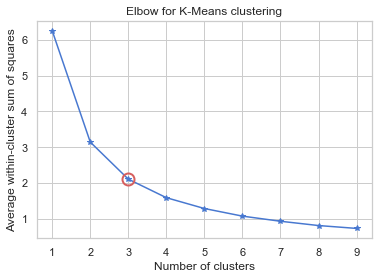

In [1164]:
kIdx = 2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K,avWithinSS, 'b*-')
ax.plot(K[kIdx], avWithinSS[kIdx], marker='o', markersize=12,
       markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')

The optimum number of cluster is 3. This parameter will be fed into K-means

#### Run K-means

In [1185]:
# set number of clusters
kclusters = K[kIdx]

Restaurant_clustering = b_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Restaurant_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:len(b_grouped)] 


array([2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

#### Prepare the final K-means dataframe

In [ ]:
# add clustering labels
lsoa_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

In [1191]:
b_merged = X_Centroids
# because I haven't updated the column name I now have to change the cluster lable to LSAO11CD!!! Annoying
b_merged=b_merged.rename({'Cluster Labels':'lsoa11cd'},axis=1)

b_merged = b_merged.join(lsoa_venues_sorted.set_index('lsoa11cd') , on='lsoa11cd')
b_merged.head() 

,lsoa11cd,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,52.480805,-1.895652,2,Coffee Shop,Gym,Sandwich Place,Church,Café,Gaming Cafe,Women's Store,Hotel,Discount Store,Deli / Bodega
1,1,52.474614,-1.915063,2,Hotel,Gym,Coffee Shop,Casino,Multiplex,Bar,Ice Cream Shop,Nightclub,Pub,Concert Hall
2,2,52.471929,-1.931923,2,Grocery Store,Music Store,Electronics Store,Insurance Office,Sandwich Place,Deli / Bodega,Comic Shop,Concert Hall,Cosmetics Shop,Discount Store
3,3,52.502859,-1.906620,2,Bakery,Betting Shop,Yoga Studio,Donut Shop,Concert Hall,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Falafel Restaurant
4,4,52.486599,-1.935536,2,Supermarket,Yoga Studio,Coffee Shop,Gaming Cafe,Furniture / Home Store,Food Truck,Falafel Restaurant,Electronics Store,Donut Shop,Discount Store


#### Visualise the clusters on a map

In [1198]:
rest_clust_type = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale = True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(b_merged['latitude'], b_merged['longitude']
                                  , b_merged['lsoa11cd'], b_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(rest_clust_type)
       
rest_clust_type

<a id='6.3'></a>

### 6.3) Examine Clusters

[Back to Table of Contents](#0)

Create a dataframe with all teh venue categories and the clusters as columns.

In [1232]:
clusters = b_merged.groupby(['Cluster Labels','lsoa11cd']).count()
clusters = clusters.reset_index()
clusters = clusters.drop(clusters.iloc[:,2:], axis=1)
clusters = clusters.set_index('lsoa11cd')

In [1250]:
clusters_c = clusters.join(b_grouped_total.set_index('lsoa11cd'), on='lsoa11cd')
clusters_c=clusters_c.groupby('Cluster Labels').sum()
clusters_c = clusters_c.transpose()
clusters_c=clusters_c.reset_index()
columns = ['Venue Category', 'Cluster 0', 'Cluster 1', 'Cluster 2']
clusters_c.columns = columns
clusters_c.head()

,Venue Category,Cluster 0,Cluster 1,Cluster 2
0,Aquarium,1,0,0
1,Art Gallery,1,1,0
2,Bakery,1,1,2
3,Bar,15,26,5
4,Betting Shop,0,0,1


Create a dataframe for each cluster

In [1261]:
cluster_c0 = clusters_c.drop(['Cluster 1','Cluster 2'],axis=1)
cluster_c1 = clusters_c.drop(['Cluster 0','Cluster 2'],axis=1)
cluster_c2 = clusters_c.drop(['Cluster 0','Cluster 1'],axis=1)

In [1258]:
cluster_c0 = cluster_c0.sort_values('Cluster 0', ascending=False)
cluster_c0.head(10)

,Venue Category,Cluster 0
3,Bar,15
15,Coffee Shop,12
9,Café,7
34,Hotel,6
53,Shopping Mall,6
52,Sandwich Place,5
14,Clothing Store,4
21,Department Store,3
43,Music Venue,3
37,Juice Bar,2


In [1259]:
cluster_c1 = cluster_c1.sort_values('Cluster 1', ascending=False)
cluster_c1.head(10)

,Venue Category,Cluster 1
3,Bar,26
15,Coffee Shop,14
50,Pub,11
9,Café,9
34,Hotel,6
20,Deli / Bodega,2
56,Supermarket,2
48,Plaza,2
47,Pie Shop,2
43,Music Venue,1


In [1262]:
cluster_c2 = cluster_c2.sort_values('Cluster 2', ascending=False)
cluster_c2.head(10)

,Venue Category,Cluster 2
34,Hotel,7
3,Bar,5
15,Coffee Shop,5
32,Gym,4
9,Café,3
52,Sandwich Place,3
53,Shopping Mall,2
56,Supermarket,2
31,Grocery Store,2
50,Pub,2


Display the volume of venues per cluster on a bar graph

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


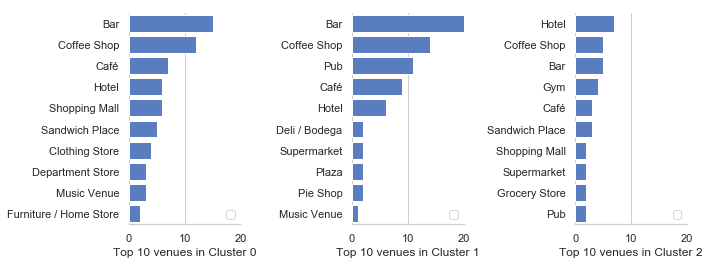

In [1280]:
sns.set(style="whitegrid")


# Initialize the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(10, 3))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=1)

# Plot cluster 0 
sns.set_color_codes("muted")
sns.barplot(ax=ax1, x="Cluster 0", y="Venue Category", data=cluster_c0.sort_values('Cluster 0', ascending=False).head(10),
            color="b")


# Plot cluster 1
sns.set_color_codes("muted")
sns.barplot(ax=ax2, x="Cluster 1", y="Venue Category", data=cluster_c1.sort_values('Cluster 1', ascending=False).head(10),
           color="b")


# Plot cluster 1
sns.set_color_codes("muted")
sns.barplot(ax=ax3, x="Cluster 2", y="Venue Category", data=cluster_c2.sort_values('Cluster 2', ascending=False).head(10),
            color="b")


# Add a legend and informative axis label
ax1.legend(ncol=1, loc="lower right", frameon=True)
ax1.set(xlim=(0, 20), ylabel="",
       xlabel="Top 10 venues in Cluster 0")

ax2.legend(ncol=1, loc="lower right", frameon=True)
ax2.set(xlim=(0, 20), ylabel="",
       xlabel="Top 10 venues in Cluster 1")

ax3.legend(ncol=1, loc="lower right", frameon=True)
ax3.set(xlim=(0, 20), ylabel="",
       xlabel="Top 10 venues in Cluster 2")

sns.despine(left=True, bottom=False)

#### Cluster analysis - Observations

##### Cluster 0

Cluster 0 has a high number of bars, coffee shops and cafés. It has hotel in forth place followed by places for shopping with a few shopping centres and other stores. There is also a few music venues

###### Cluster 1

Cluster 1 has a high volume of bars followed by coffee shops. Pubs come in third place.

##### Cluster 2

This cluster has got hotels in first place then coffee shops and bars. Gyms are in fourth position. This cluster has a few shooping centres but not as many as cluster 0. It has sandwich places, supermarkets and grocery stores with pubs coming last.

<a id='7'></a>

### 7) Results/Recommendations

[Back to Table of Contents](#0)

As very often answers are not necessarily obvious and there is not one perfect solution but a few options to consider. By looking at the above analysis, three areas could be considered of some interest: 

#### Option A: Around Brindley place (DBSCAN cluster 8 and k-means cluster 0)
The pros:

This location has got a high volume of restaurants, bars, cafés and stores that are likely to attract the type of customers our fictitious steakhouse chain would like to target. Combine with the presence of stores and hotels in the area, foot traffic must be fairly high. This location is a close to a good catchment areas made of residents in the target age group (21-29) having a fairly high weekly spending in restaurants and hotels.

The cons:

It would need to be considered the high concentration of restaurants in the area. Is the local market saturated? How well competitors are doing in this area. The high foot traffic must also equate to higher rents but this is likely to be the case with any locations near the city centre. Despite being close to good catchment areas it is at the boundaries of an area with lower spending. The workplace population is also lower than other locations

#### Option B: Near the Mailbox (DBSCAN cluster 7 and k-means cluster 2)
The pros:

This appear to be the second place with a high density of restaurants therefore foot traffic should be high. This location is in an area where residents in the target group have a high spending in restaurants and hotels. It seems to be situated close to shopping centres.  

The cons:

One of the main issue with this area is that there are already two steakhouse restaurant. Would a third one be viable? Also this area does not seem to have as much going on as in Option A (and C that will be covered below).

#### Option C: Near Victoria Square (DBSCAN cluster 19, 20 and k-means cluster 1)
The pros:

High number of bars, pubs, cafés and hotels. Because right in the middle of the City Centre, very likely to have high foot traffic. The city centre is surrounded by areas with residents in the target group age spending the most in restaurants and hotels. It also has the highest volume of workers in the area. There is some competition already there but it does not seem as concentrated than in option A and B.

The cons:

Despite having a high volume of workers, there are very few residents. Are customers drawn into the city centre at the weekend? Or are they more likely to go to shopping centres? Also what is the activity in the evening once workers are back home?

[Back to Table of Contents](#0)